In [1]:
# Always run this first
# NOTE: Do not define new basic variables in this notebook;
#       define them in Variables_Q.ipynb.  Use this notebook
#       to define new expressions built from those variables.

from __future__ import division # This needs to be here, even though it's in Variables.py
import sys
sys.path.insert(0, '..') # Look for modules in directory above this one
execfile('../Utilities/ExecNotebook.ipy')
#try: execnotebook(VariablesNotebook)
#except: execnotebook('../PNTerms/Variables_Q.ipynb')

This notebook provides a couple examples for how to convert long $\LaTeX$ expression into sympy format, via Mathematica.

# EMRI terms

The first step is to select the equation you want from the original source (possibly obtained from the "Other Formats" link on the paper's arXiv page), and put it in its own file.  Here, we have an example named `EMRIGWFlux_7PN.tex` taken from [Fujita (2012)](http://arxiv.org/abs/1211.5535v1).  It is best to copy this exactly, without making any changes

The next step is to run this through perl, and let perl make any necessary replacements.  Mathematica won't want any `\begin{equation}` statements, so we remove them first.  Next, we probably want to remove the left-hand side of the equation, which is just the variable name that this expression represents.  We correct any mistakes in the original (the use of `{\rm ln}` instead of `\ln`, for example), and remove anything else Mathematica won't understand.

In [1]:
%%bash
perl -nlw \
    -e 's/\\begin\{eqnarray\*\}//g; s/\\end\{eqnarray\*\}//g; ' `# remove environment for Mathematica` \
    -e 's/\{dE\\over dt\}=&&\\left\(\{dE\\over dt\}\\right\)_N//;' `# remove definition statement` \
    -e 's/\{\\rm ln\}/\\ln/g;' `# Correct bad notation for logarithm` \
    -e 's/\\cr//g; s/\\displaystyle//g;' `# These shouldn't have been in there to begin with` \
    -e 's/(\\ln\(.\))(\^\{.\})/($1)$2/g;' `# group logarithm powers correctly` \
    -e 's/\\\{/(/g; s/\\\}/)/g; s/\[/(/g; s/\]/)/g;' `# convert braces and brackets to parentheses` \
    -e 's/\),/\)/;' `# remove final punctuation` \
    -e 'print if /\S/;' `# only print line if nonempty` \
    EMRIGWFlux_7PN.tex > EMRIGWFlux_7PN_Simplified.tex
#cat EMRIGWFlux_7PN_Simplified.tex

Next, we just need to run this through Mathematica, which has a good TeX conversion method.  Of course, Mathematica's output is weird — all the function names are capitalized; function arguments come in square brackets; etc.  So we just replace them in the output.  Then, we go through and print the terms at each order, ready to be copied to another notebook.  (Or we could just use the sympy object `Flux` below.)

*NOTE:* You will need to adjust the `MathKernel` path below.  On Linux, you will need the executable named `math` instead.

In [4]:
MathKernel='/Applications/Local/Mathematica.app/Contents/MacOS/MathKernel'
FluxCommand = r"""
\[Gamma] = EulerGamma;
\[Zeta] = Zeta;
HornerForm[ToExpression[Import[
    "EMRIGWFlux_7PN_Simplified.tex",
    "Text"], TeXForm]] >> /tmp/Flux.cpp
Exit[];
"""
! {MathKernel} -run '{FluxCommand}' >& /dev/null
Flux = !cat /tmp/flux.cpp
Flux = ''.join(Flux).replace(' ','').replace('Pi','pi').replace('Log','log').replace('Zeta','zeta').replace('Power','Pow')
Flux = Flux.replace('[','(').replace(']',')').replace('^','**')
Flux = sympify(Flux)

logv = symbols('logv')
FluxDictionary = Poly(Flux.subs('log(v)', logv), Flux.atoms(Symbol).pop()).as_dict()

for key in sorted(FluxDictionary) :
    if(key[0]>7) :
        print("FluxTerms['IncompleteNonspinning'][{0}] = {1}".format(key[0], FluxDictionary[key].subs(logv, log(v))))

FluxTerms['IncompleteNonspinning'][8] = 232597*log(v)/4410 - 1369*pi**2/126 - 323105549467/3178375200 - 47385*log(3)/1568 + 232597*EulerGamma/4410 + 39931*log(2)/294
FluxTerms['IncompleteNonspinning'][9] = -6848*pi*log(v)/105 - 13696*pi*log(2)/105 - 6848*EulerGamma*pi/105 + 265978667519*pi/745113600
FluxTerms['IncompleteNonspinning'][10] = 916628467*log(v)/7858620 - 2500861660823683/2831932303200 - 424223*pi**2/6804 - 83217611*log(2)/1122660 + 916628467*EulerGamma/7858620 + 47385*log(3)/196
FluxTerms['IncompleteNonspinning'][11] = 177293*pi*log(v)/1176 - 142155*pi*log(3)/784 + 8399309750401*pi/101708006400 + 177293*EulerGamma*pi/1176 + 8521283*pi*log(2)/17640
FluxTerms['IncompleteNonspinning'][12] = 1465472*log(v)**2/11025 - 246137536815857*log(v)/157329572400 - 27392*pi**2*log(v)/315 + 2930944*EulerGamma*log(v)/11025 + 5861888*log(2)*log(v)/11025 - 271272899815409*log(2)/157329572400 - 54784*pi**2*log(2)/315 - 246137536815857*EulerGamma/157329572400 - 437114506833*log(3)/789268480 - 2

Just for fun, let's look at the actual expression:

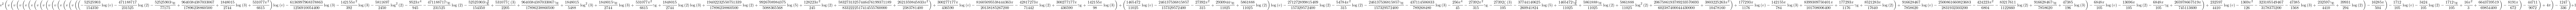

In [5]:
Flux

# PN angular momentum

In [12]:
from sympy import *
ellHat= Symbol('ellHat')
nHat= Symbol('nHat')
lambdaHat= Symbol('lambdaHat')
var('v, m, nu, G, c, x');

In [4]:
def MathematicaToSympy(L):
    import re
    L = ''.join(L).replace(' ','')
    L = L.replace(r'\[ScriptL]','ell')
    MathematicaCapitalGreek = re.compile(r'\\ \[ Capital(.*?) \]', re.VERBOSE)
    L = MathematicaCapitalGreek.sub(r'\1',L)
    MathematicaGreek = re.compile(r'\\ \[ (.*?) \]', re.VERBOSE)
    L = MathematicaGreek.sub(lambda m: m.group(1).lower(),L)
    OverHat = re.compile(r'OverHat\[ (.*?) \]', re.VERBOSE)
    L = OverHat.sub(r'\1Hat',L)
    Subscript = re.compile(r'Subscript\[ (.*?), (.*?) \]', re.VERBOSE)
    L = Subscript.sub(r'\1_\2',L)
    Sqrt = re.compile(r'Sqrt\[ (.*?) \]', re.VERBOSE)
    L = Sqrt.sub(r'sqrt(\1)',L)
    L = L.replace('Pi','pi').replace('Log','log').replace('Zeta','zeta').replace('Power','Pow')
    L = L.replace('^','**')
    return L

In [5]:
MathKernel='/Applications/Local/Mathematica.app/Contents/MacOS/MathKernel'
MCommand = r"""
\[Gamma] = EulerGamma;
\[Zeta] = Zeta;
HornerForm[ToExpression[Import[
    "AngularMomentum.tex",
    "Text"], TeXForm],x] >> /tmp/AngularMomentum.cpp
Exit[];
"""
! {MathKernel} -run '{MCommand}' >& /dev/null
L = !cat /tmp/AngularMomentum.cpp
L = MathematicaToSympy(L)
L = sympify(L).subs('sqrt(x)',v).subs('x',v**2).subs('G',1).subs('c',1).simplify()

NameError: name 'v' is not defined

In [14]:
L_ellHat = horner( (v*L).simplify().expand().coeff(ellHat) )/v
L_nHat = horner( (v*L).simplify().expand().coeff(nHat) )/v
L_lambdaHat = horner( (v*L).simplify().expand().coeff(lambdaHat) )/v

In [19]:
L_set = [L_ellHat, L_nHat, L_lambdaHat]

for n in range(3,9,2):
    print("""AngularMomentum_Spin.AddDerivedVariable('L_SO_{0}',
    ({1})*ellHat
    + ({2})*nHat
    + ({3})*lambdaHat,
    datatype=ellHat.datatype)""".format(n,
                                        (v*L_ellHat/(m**2*nu)).expand().coeff(v**n).simplify(),
                                        (v*L_nHat/(m**2*nu)).expand().coeff(v**n).simplify(),
                                        (v*L_lambdaHat/(m**2*nu)).expand().coeff(v**n).simplify()))

BindingEnergy_Spin.AddDerivedVariable('L_SO_3',
    (-(35*S_ell + 15*Sigma_ell*delta)/(6*m**2))*ellHat
    + ((S_n + Sigma_n*delta)/(2*m**2))*nHat
    + (-(3*S_lambda + Sigma_lambda*delta)/m**2)*lambdaHat,
    datatype=ellHat.datatype)
BindingEnergy_Spin.AddDerivedVariable('L_SO_5',
    (7*(61*S_ell*nu - 99*S_ell + 30*Sigma_ell*delta*nu - 27*Sigma_ell*delta)/(72*m**2))*ellHat
    + ((-19*S_n*nu + 33*S_n - 10*Sigma_n*delta*nu + 33*Sigma_n*delta)/(24*m**2))*nHat
    + ((18*S_lambda*nu - 21*S_lambda + 8*Sigma_lambda*delta*nu - 3*Sigma_lambda*delta)/(6*m**2))*lambdaHat,
    datatype=ellHat.datatype)
BindingEnergy_Spin.AddDerivedVariable('L_SO_7',
    ((-29*S_ell*nu**2 + 1101*S_ell*nu - 405*S_ell - 15*Sigma_ell*delta*nu**2 + 468*Sigma_ell*delta*nu - 81*Sigma_ell*delta)/(16*m**2))*ellHat
    + ((11*S_n*nu**2 - 1331*S_n*nu + 183*S_n + 5*Sigma_n*delta*nu**2 - 734*Sigma_n*delta*nu + 183*Sigma_n*delta)/(48*m**2))*nHat
    + ((-32*S_lambda*nu**2 + 2*S_lambda*nu - 174*S_lambda - 16*Sigma_lambda*de

In [148]:
for var in [L_ellHat, L_nHat, L_lambdaHat]:
    print ccode(N(var,16))

(nu + pow(v, 2)*(nu*(0.1666666666666667*nu + 1.5) + v*(-5.833333333333333*S_ell*nu - 2.5*Sigma_ell*delta*nu + v*(nu*(nu*(0.04166666666666667*nu - 2.375) + 3.375) + v*(S_ell*nu*(5.930555555555556*nu - 9.625) + Sigma_ell*delta*nu*(2.916666666666667*nu - 2.625) + v*(nu*(nu*(nu*(0.005401234567901235*nu + 1.291666666666667) - 30.97970359258346) + 8.4375) + v*(S_ell*nu*(nu*(-1.8125*nu + 68.8125) - 25.3125) + Sigma_ell*delta*nu*(nu*(-0.9375*nu + 29.25) - 5.0625))))))))/v
pow(v, 2)*(0.5*S_n*nu + 0.5*Sigma_n*delta*nu + pow(v, 2)*(S_n*nu*(-0.7916666666666667*nu + 1.375) + Sigma_n*delta*nu*(-0.4166666666666667*nu + 1.375) + pow(v, 2)*(S_n*nu*(nu*(0.2291666666666667*nu - 27.72916666666667) + 3.8125) + Sigma_n*delta*nu*(nu*(0.1041666666666667*nu - 15.29166666666667) + 3.8125))))
pow(v, 2)*(-3.0*S_lambda*nu - Sigma_lambda*delta*nu + pow(v, 2)*(S_lambda*nu*(3.0*nu - 3.5) + Sigma_lambda*delta*nu*(1.333333333333333*nu - 0.5) + pow(v, 2)*(S_lambda*nu*(nu*(-1.333333333333333*nu + 0.08333333333333333) - 7

# Binding energy

In [44]:
%%bash --out tmp
perl -nlw \
    -e 's/\\begin\{eqnarray\}//g; s/\\end\{eqnarray\}//g; ' `# remove environment for Mathematica` \
    -e 's/\\label\{eB6PN\}//;' `# remove equation label` \
    -e 's/\\nonumber//g; s/\\biggl//g; s/\\Biggl//g; s/\\left//g; s/\\right//g;' `# remove irrelevant formatting` \
    -e 's/\&//g; s/\\\\//g;' `# remove alignments and newlines` \
    -e 's/\\\{/(/g; s/\\\}/)/g; s/\[/(/g; s/\]/)/g;' `# convert braces and brackets to parentheses` \
    -e 's/\),/\)/;' `# remove final punctuation` \
    -e 'print if /\S/;' `# only print line if nonempty` \
    BindingEnergy.tex > BindingEnergy_Simplified.tex
cat BindingEnergy_Simplified.tex

In [45]:
tmp

'e_{\\rm 1PN} (\\nu)=  -\\frac{1}{12}\\nu-\\frac34 \ne_{\\rm 2PN} (\\nu)=  -\\frac{1}{24}\\nu^2+\\frac{19}8 \\nu-\\frac{27}{8}\ne_{\\rm 3PN} (\\nu)= -\\frac{35}{5184}\\nu^3 -\\frac{155}{96}\\nu^2+\\frac{34445}{576}\\nu-\\frac{205}{96}\\pi^2\\nu-\\frac{675}{64}  \ne_{\\rm 4PN}^c (\\nu)= -\\frac{3969}{128}+\\frac{77}{31104}\\nu^4+\\frac{301}{1728}\\nu^3\n+(-\\frac{498449}{3456} +\\frac{3157}{576}\\pi^2)\\nu^2\n+(-\\frac{123671}{5760}+\\frac{1792}{15} \\ln(2)+\\frac{9037}{1536} \\pi^2\n+\\frac{896}{15} \\gamma)\\nu \ne_{\\rm 4PN}^{\\ln}(\\nu)= \\frac{448}{15}\\nu  \ne_{\\rm 5PN}^c (\\nu)= -\\frac{45927}{512}+\\frac{1}{512}\\nu^5+\\frac{55}{512}\\nu^4\n+(-\\frac{1353}{256}\\pi^2+\\frac{69423}{512} )\\nu^3\n+(-\\frac{21337}{1024}\\pi^2+3 a_6^{c1}\n-\\frac{896}{5}\\ln(2)-\\frac{448}{5}\\gamma+\\frac{189745}{576}+\\frac{2}{3}a_{6}^{\\ln 1})\\nu^2\n+(-\\frac{228916843}{115200}-\\frac{9976}{35}\\gamma+\\frac{729}{7}\\ln(3) \n -\\frac{23672}{35}\\ln(2)+\\frac{126779}{512}\\pi^2 )\\nu \ne_{\\rm 5

In [62]:
from __future__ import print_function
Terms = ['E_2', 'E_4', 'E_6', 'E_8', 'E_lnv_8', 'E_10', 'E_lnv_10', 'E_11', 'E_12', 'E_lnv_12']
Expressions = [s[(s.index('=')+1):].replace('\n','') for s in tmp.split('\ne')]
for t,e in zip(Terms,Expressions):
    print(e, file=open('/tmp/'+t+'.tex','w+'))

In [107]:
import re
MathKernel='/Applications/Local/Mathematica.app/Contents/MacOS/MathKernel'
BindingEnergyCommand = r"""
\[Gamma] = EulerGamma;
HornerForm[ToExpression[Import[
    "/tmp/{0}.tex",
    "Text"], TeXForm]] >> /tmp/{0}.cpp
Exit[];
"""
for t in Terms:
    ! {MathKernel} -run '{BindingEnergyCommand.format(t)}' >& /dev/null
    BindingEnergy = !cat /tmp/{t}.cpp
    BindingEnergy = ''.join(BindingEnergy).replace(' ','').replace('Pi','pi').replace('Log','log').replace('Nu','nu')
    BindingEnergy = BindingEnergy.replace('[','(').replace(']',')').replace('Power','Pow').replace('^','**').replace('\\','')
    BindingEnergy = re.sub(r'Subscript\((.*?),([0-9])[.5]*\)\*\*(c|ln)', r'\1_\2__\g<3>1', BindingEnergy)
    BindingEnergy = sympify(BindingEnergy)

    logv = symbols('logv')
    BindingEnergy = BindingEnergy.subs('log(v)', logv)
    
    print("BindingEnergy_NoSpin_B.AddDerivedConstant('{0}', {1})".format(t, BindingEnergy))
    print()

BindingEnergy_NoSpin_B.AddDerivedConstant('E_2', -nu/12 - 3/4)

BindingEnergy_NoSpin_B.AddDerivedConstant('E_4', nu*(-nu/24 + 19/8) - 27/8)

BindingEnergy_NoSpin_B.AddDerivedConstant('E_6', nu*(nu*(-35*nu/5184 - 155/96) - 205*pi**2/96 + 34445/576) - 675/64)

BindingEnergy_NoSpin_B.AddDerivedConstant('E_8', nu*(nu*(nu*(77*nu/31104 + 301/1728) - 498449/3456 + 3157*pi**2/576) - 123671/5760 + 896*EulerGamma/15 + 9037*pi**2/1536 + 1792*log(2)/15) - 3969/128)

BindingEnergy_NoSpin_B.AddDerivedConstant('E_lnv_8', 448*nu/15)

BindingEnergy_NoSpin_B.AddDerivedConstant('E_10', nu*(nu*(3*a_6__c1 + 2*a_6__ln1/3 + nu*(nu*(nu/512 + 55/512) - 1353*pi**2/256 + 69423/512) - 21337*pi**2/1024 - 896*log(2)/5 - 448*EulerGamma/5 + 189745/576) - 228916843/115200 - 23672*log(2)/35 - 9976*EulerGamma/35 + 729*log(3)/7 + 126779*pi**2/512) - 45927/512)

BindingEnergy_NoSpin_B.AddDerivedConstant('E_lnv_10', nu*(nu*(3*a_6__ln1 - 224/5) - 4988/35))

BindingEnergy_NoSpin_B.AddDerivedConstant('E_11', 10*nu(a_6__c1*nu 

In [6]:
import re
from sympy import sympify, symbols
for i in [1]:
    BindingEnergy = !cat /tmp/E_lnv_12.cpp
    print(BindingEnergy)
    BindingEnergy = ''.join(BindingEnergy).replace(' ','').replace('Pi','pi').replace('Log','log').replace('Nu','nu')
    print(BindingEnergy)
    BindingEnergy = BindingEnergy.replace('[','(').replace(']',')').replace('Power','Pow').replace('^','**').replace('\\','')
    print(BindingEnergy)
    BindingEnergy = re.sub(r'Subscript\((.*?),([0-9])[.5]*\)\*\*(c|ln)', r'\1_\2__\g<3>1', BindingEnergy)
    print(BindingEnergy)
    BindingEnergy = sympify(BindingEnergy)
    print(BindingEnergy)

    logv = symbols('logv')
    BindingEnergy = BindingEnergy.subs('log(v)', logv)
    
    print("BindingEnergy_NoSpin_B.AddDerivedConstant('E_lnv_12', {0})".format(BindingEnergy))
    print()

['\\[Nu]*(-1967284/8505 + \\[Nu]*(56386/105 + (11*Subscript[a, 6]^ln)/2 + ', '     \\[Nu]*(616/27 - (11*Subscript[a, 6]^ln)/2))) + (11*Subscript[a, 7]^ln)/3']
\[nu]*(-1967284/8505+\[nu]*(56386/105+(11*Subscript[a,6]^ln)/2+\[nu]*(616/27-(11*Subscript[a,6]^ln)/2)))+(11*Subscript[a,7]^ln)/3
(nu)*(-1967284/8505+(nu)*(56386/105+(11*Subscript(a,6)**ln)/2+(nu)*(616/27-(11*Subscript(a,6)**ln)/2)))+(11*Subscript(a,7)**ln)/3
(nu)*(-1967284/8505+(nu)*(56386/105+(11*a_6__ln1)/2+(nu)*(616/27-(11*a_6__ln1)/2)))+(11*a_7__ln1)/3
11*a_7__ln1/3 + nu*(nu*(11*a_6__ln1/2 + nu*(-11*a_6__ln1/2 + 616/27) + 56386/105) - 1967284/8505)
BindingEnergy_NoSpin_B.AddDerivedConstant('E_lnv_12', 11*a_7__ln1/3 + nu*(nu*(11*a_6__ln1/2 + nu*(-11*a_6__ln1/2 + 616/27) + 56386/105) - 1967284/8505))
()


In [ ]:
nu*(nu*(11*a_6__ln1/2 + nu*(-11*a_6__ln1/2 + 616/27) + 56386/105) - 1967284/8505)

In [ ]:
11*self.a_7__ln1/3 + nu*(nu*(11*self.a_6__ln1/2 + nu*(-11*self.a_6__ln1/2 + 616/27 + 56386/105) - 1967284/8505))